In [ ]:
!pip3 uninstall tensorflow-gpu==1.14
!pip3 install tensorflow==1.13.1
# !pip3 uninstall tensorflow
# !pip3 install tensorflow-gpu==1.14

In [ ]:
!pip3 install keras==2.0.8

     |████████████████████████████████| 276kB 19.7MB/s 
ERROR: fancyimpute 0.4.3 requires tensorflow, which is not installed.
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.8 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
!pip3 install keras==2.2.4

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/unshuffled_norm_combined_data_train1.csv')
data2 = pd.DataFrame(columns = [ 'Transfer', 'Bandwidth', 'CongestionWindow','RTT', 'NetPower'])

data2['Transfer'] = df['Transfer']
data2['Bandwidth'] = df['Bandwidth']
data2['CongestionWindow'] = df['CongestionWindow']
data2['RTT'] = df['RTT'] * 100
data2['NetPower'] = df['NetPower']
train_set = data2.values

In [ ]:
print(data2['RTT'])

0         0.000161
1         0.000085
2         0.000087
3         0.000069
4         0.000069
            ...   
201307    0.028603
201308    0.028603
201309    0.028603
201310    0.028603
201311    0.028603
Name: RTT, Length: 201312, dtype: float64


In [ ]:
train_X=[]
train_Y=[]
for i in range(100, len(train_set)):

        train_X.append(train_set[i-100:i,:])
        train_Y.append(train_set[i-1:i,:])

In [ ]:
import numpy as np
X_train = np.array(train_X)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 5))
print(X_train.shape)

(201212, 100, 5)


In [ ]:
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import load_model

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [ ]:
latent_dim=32

encoder_inputs =  Input(shape=( X_train.shape[1],5), dtype='float32')
encoder = Bidirectional(LSTM(latent_dim, return_state=True))

encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]


# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_inputs = Input(shape=(1,5))
decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(5,activation='relu')
decoder_outputs = decoder_dense(decoder_outputs)
regressor = Model([encoder_inputs, decoder_inputs], decoder_outputs)

regressor.compile(optimizer = "rmsprop", loss = 'mean_absolute_error')
encoder_input_data=X_train
print(X_train.shape)
decoder_target_data=np.array(train_Y).astype(np.float32)
print(decoder_target_data.shape)
decoder_input_data = np.zeros(decoder_target_data.shape)
print(decoder_input_data.shape)
regressor.fit([encoder_input_data, decoder_input_data], decoder_target_data, epochs=1, batch_size=256)

regressor.save("/content/drive/MyDrive/RTT-seq2seq.h5")

Instructions for updating:
Colocations handled automatically by placer.
(201212, 100, 5)
(201212, 1, 5)
(201212, 1, 5)
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
201212/201212 [==============================] - 222s 1ms/step - loss: 0.0109


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_1/concat:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [ ]:
regressor = load_model("/content/drive/MyDrive/RTT-seq2seq.h5")
testdataframe = pd.read_csv("/content/drive/MyDrive/unshuffled_norm_combined_data_train1.csv")

testdata = pd.DataFrame(columns = [ 'Transfer', 'Bandwidth', 'CongestionWindow','RTT', 'NetPower'])

testdata['Transfer'] = testdataframe['Transfer']
testdata['Bandwidth'] = testdataframe['Bandwidth']
testdata['CongestionWindow'] = testdataframe['CongestionWindow']
testdata['RTT'] = testdataframe['RTT'] * 100
testdata['NetPower'] = testdataframe['NetPower']

dataset_total = pd.concat((data2,testdata),axis=0)



In [ ]:
inputs = dataset_total[len(dataset_total) - len(testdata) - 100:].values
print(inputs)
print(inputs.shape)

[[0.         0.         0.00014459 0.0286025  0.        ]
 [0.         0.         0.00014459 0.0286025  0.        ]
 [0.         0.         0.00014459 0.0286025  0.        ]
 ...
 [0.         0.         0.00014459 0.0286025  0.        ]
 [0.         0.         0.00014459 0.0286025  0.        ]
 [0.         0.         0.00014459 0.0286025  0.        ]]
(201412, 5)


In [ ]:
test_X=[]
test_Y=[]
for i in range(100, len(inputs)):

        test_X.append(inputs[i-100:i,:])
        test_Y.append(inputs[i-1:i,:])

X_test = np.array(test_X)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))

Y_test = np.array(test_Y).astype(np.float32)
decoder_output_target = Y_test
decoder_output_data = np.zeros(decoder_output_target.shape)


(201312, 100, 5)


In [ ]:
predicted= regressor.predict([X_test,decoder_output_data])
print(predicted.shape)

(201312, 1, 5)


In [ ]:
predicted = predicted.reshape(predicted.shape[0],5)
Y_test = Y_test.reshape(Y_test.shape[0],5)

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
rmse1=np.sqrt(np.mean(((predicted[50:,0]- Y_test[50:,0])**2)))
rmse2=np.sqrt(np.mean(((predicted[50:,1]- Y_test[50:,1])**2)))
rmse3=np.sqrt(np.mean(((predicted[50:,2]- Y_test[50:,2])**2)))
rmse4=np.sqrt(np.mean(((predicted[50:,3]- Y_test[50:,3])**2)))
rmse5=np.sqrt(np.mean(((predicted[50:,4]- Y_test[50:,4])**2)))
print(mean_squared_error(predicted[50:,0],Y_test[50:,0]))
print(mean_squared_error(predicted[50:,1],Y_test[50:,1]))
print(mean_squared_error(predicted[50:,2],Y_test[50:,2]))
print(mean_squared_error(predicted[50:,3], Y_test[50:,3]))
print(mean_squared_error(predicted[50:,4], Y_test[50:,4]))
print("****")
print(rmse1)
print(rmse2)
print(rmse3)
print(rmse4)
print(rmse5)


0.0003227835
0.00024242606
3.788152e-05
0.02406877
0.00014343356
****
0.017966177
0.015570037
0.0061547966
0.15514113
0.011976375


In [ ]:
print(predicted[:,3])
print(Y_test[:,3])

[0.         0.05919327 0.11599086 ... 0.         0.         0.        ]
[0.         0.06403229 0.12127576 ... 0.         0.         0.        ]


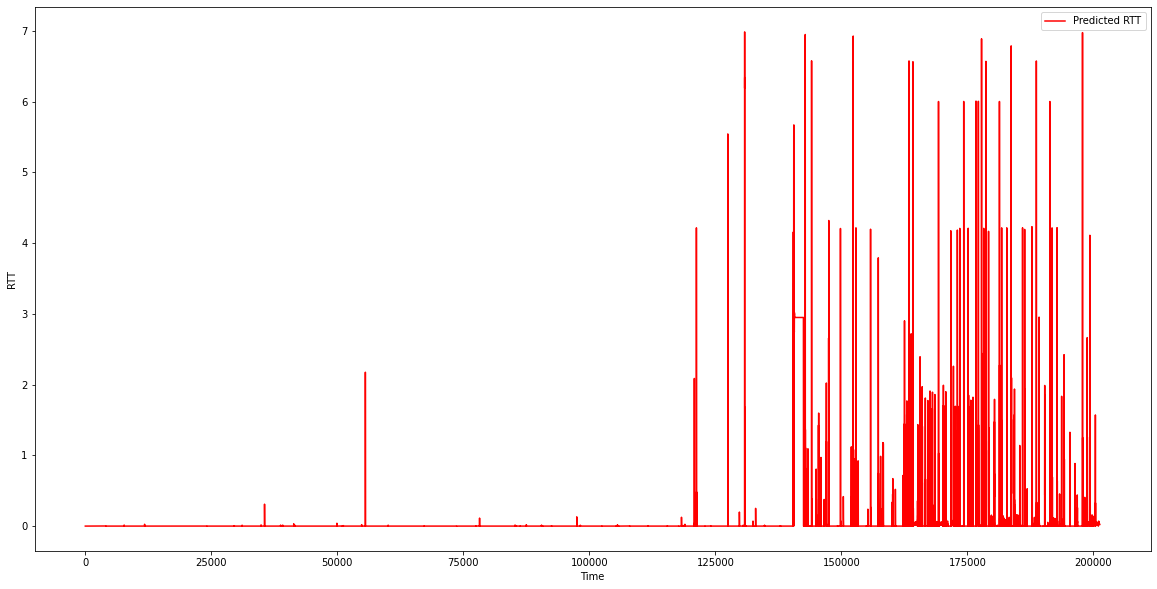

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(predicted[50:,3], color = 'red', label = 'Predicted RTT')
plt.xlabel('Time')
plt.ylabel('RTT')
plt.legend()
plt.show()

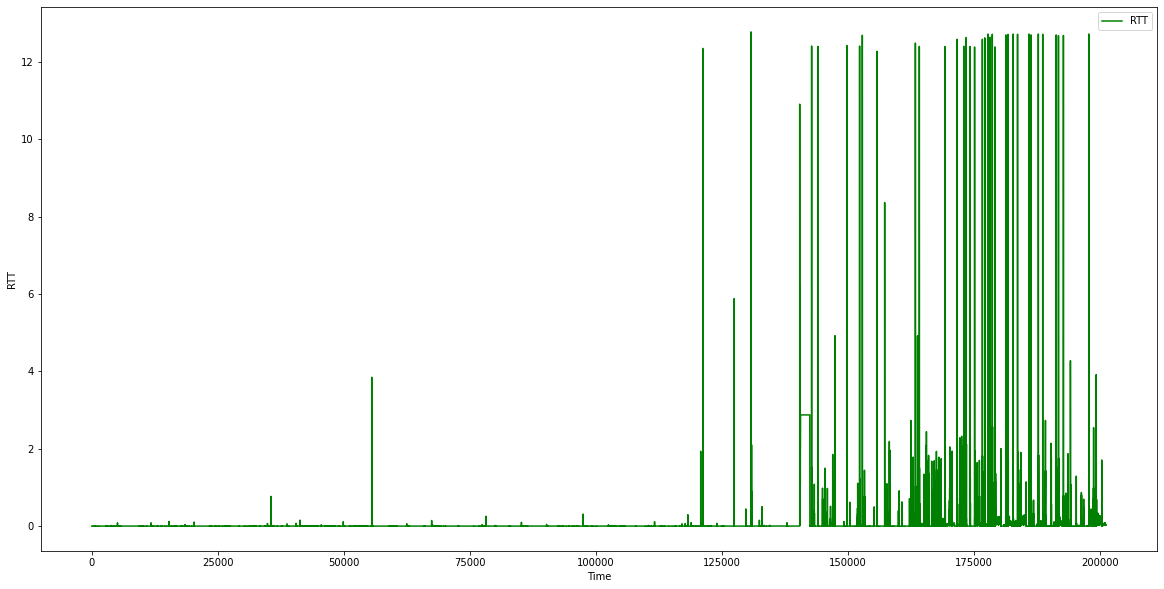

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(Y_test[50:,3], color = 'green', label = 'RTT')
# plt.plot(predicted[50:,0], color = 'red', label = 'Predicted Transfer')
plt.xlabel('Time')
plt.ylabel('RTT')
plt.legend()
plt.show()

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/unshuffled_norm_combined_data_train2.csv')
data2 = pd.DataFrame(columns = [ 'Transfer', 'Bandwidth', 'CongestionWindow','RTT', 'NetPower'])

data2['Transfer'] = df['Transfer']
data2['Bandwidth'] = df['Bandwidth']
data2['CongestionWindow'] = df['CongestionWindow']
data2['RTT'] = df['RTT'] * 100
data2['NetPower'] = df['NetPower']
train_set = data2.iloc[:,:].values

In [ ]:
train_X=[]
train_Y=[]
for i in range(100, len(train_set)):

        train_X.append(train_set[i-100:i,:])
        train_Y.append(train_set[i-1:i,:])

In [ ]:
X_train = np.array(train_X)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 5))

In [ ]:
regressor = load_model("/content/drive/MyDrive/RTT-seq2seq.h5")
encoder_input_data=X_train
print(X_train.shape)
decoder_target_data=np.array(train_Y).astype(np.float32)
print(decoder_target_data.shape)
decoder_input_data = np.zeros(decoder_target_data.shape)
print(decoder_input_data.shape)
regressor.fit([encoder_input_data, decoder_input_data], decoder_target_data, epochs=1, batch_size=256)
regressor.save("/content/drive/MyDrive/RTT-seq2seq_data2.h5")


(201212, 100, 5)
(201212, 1, 5)
(201212, 1, 5)
Epoch 1/1
201212/201212 [==============================] - 233s 1ms/step - loss: 0.0119


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_1_2/concat:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'concatenate_2_2/concat:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [ ]:
regressor = load_model("/content/drive/MyDrive/RTT-seq2seq_data2.h5")
testdataframe = pd.read_csv("/content/drive/MyDrive/unshuffled_norm_combined_data_train2.csv")

testdata = pd.DataFrame(columns = [ 'Transfer', 'Bandwidth', 'CongestionWindow','RTT', 'NetPower'])

testdata['Transfer'] = testdataframe['Transfer']
testdata['Bandwidth'] = testdataframe['Bandwidth']
testdata['CongestionWindow'] = testdataframe['CongestionWindow']
testdata['RTT'] = testdataframe['RTT'] * 100
testdata['NetPower'] = testdataframe['NetPower']

dataset_total = pd.concat((data2,testdata),axis=0)

In [ ]:
inputs = dataset_total[len(dataset_total) - len(testdata) - 100:].values
print(inputs)
print(inputs.shape)

[[1.04492188e-01 4.48448400e-03 5.20532100e-03 6.49000000e-05
  3.84302400e-02]
 [6.58203130e-02 2.83283300e-03 5.20532100e-03 6.49000000e-05
  2.42551520e-02]
 [5.64453130e-02 2.42242200e-03 5.20532100e-03 7.42000000e-05
  1.81913640e-02]
 ...
 [8.68164060e-02 3.73373400e-03 3.75939800e-03 6.86000000e-05
  3.02657300e-02]
 [8.39843750e-02 3.61361400e-03 3.75939800e-03 6.68000000e-05
  3.01001880e-02]
 [5.26367190e-02 2.26226200e-03 3.75939800e-03 1.47000000e-04
  8.59277500e-03]]
(201412, 5)


In [ ]:
test_X=[]
test_Y=[]
for i in range(100, len(inputs)):

        test_X.append(inputs[i-100:i,:])
        test_Y.append(inputs[i-1:i,:])

X_test = np.array(test_X)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))

Y_test = np.array(test_Y).astype(np.float32)
decoder_output_target = Y_test
decoder_output_data = np.zeros(decoder_output_target.shape)

(201312, 100, 5)


In [ ]:
predicted = regressor.predict([X_test,decoder_output_data])
print(predicted.shape)

(201312, 1, 5)


In [ ]:
predicted = predicted.reshape(predicted.shape[0],5)
Y_test = Y_test.reshape(Y_test.shape[0],5)

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
rmse1=np.sqrt(np.mean(((predicted[50:,0]- Y_test[50:,0])**2)))
rmse2=np.sqrt(np.mean(((predicted[50:,1]- Y_test[50:,1])**2)))
rmse3=np.sqrt(np.mean(((predicted[50:,2]- Y_test[50:,2])**2)))
rmse4=np.sqrt(np.mean(((predicted[50:,3]- Y_test[50:,3])**2)))
rmse5=np.sqrt(np.mean(((predicted[50:,4]- Y_test[50:,4])**2)))
print(mean_squared_error(predicted[50:,0],Y_test[50:,0]))
print(mean_squared_error(predicted[50:,1],Y_test[50:,1]))
print(mean_squared_error(predicted[50:,2],Y_test[50:,2]))
print(mean_squared_error(predicted[50:,3], Y_test[50:,3]))
print(mean_squared_error(predicted[50:,4], Y_test[50:,4]))
print("****")
print(rmse1)
print(rmse2)
print(rmse3)
print(rmse4)
print(rmse5)

7.643565e-05
0.00031029436
4.0193823e-05
0.07477115
1.40035245e-05
****
0.008742749
0.017615175
0.0063398597
0.27344313
0.0037421284


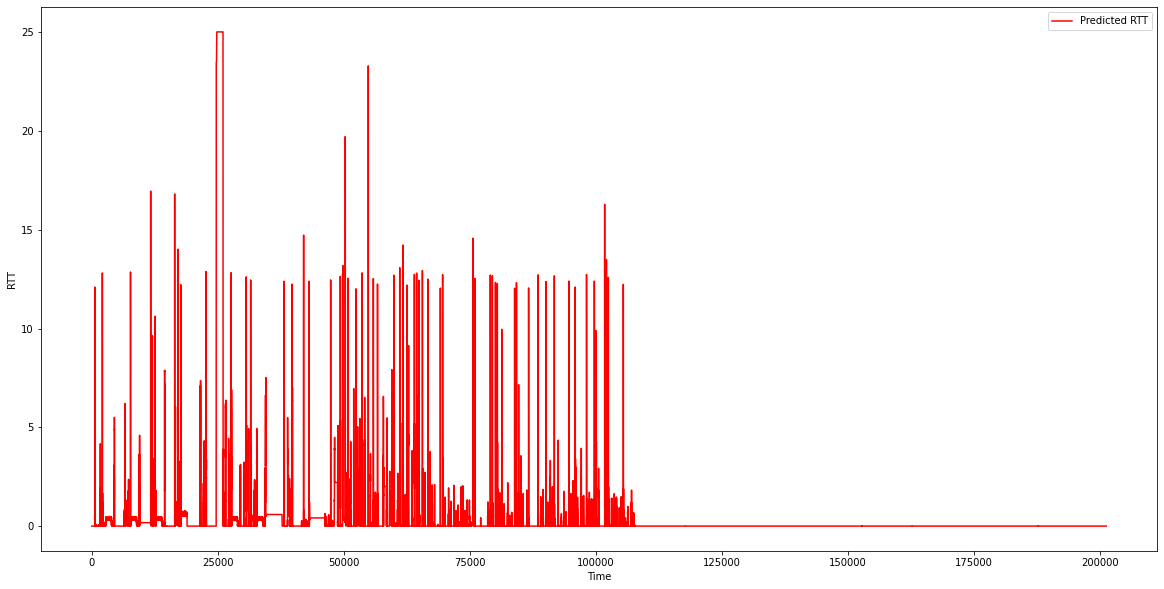

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(predicted[50:,3], color = 'red', label = 'Predicted RTT')
plt.xlabel('Time')
plt.ylabel('RTT')
plt.legend()
plt.show()

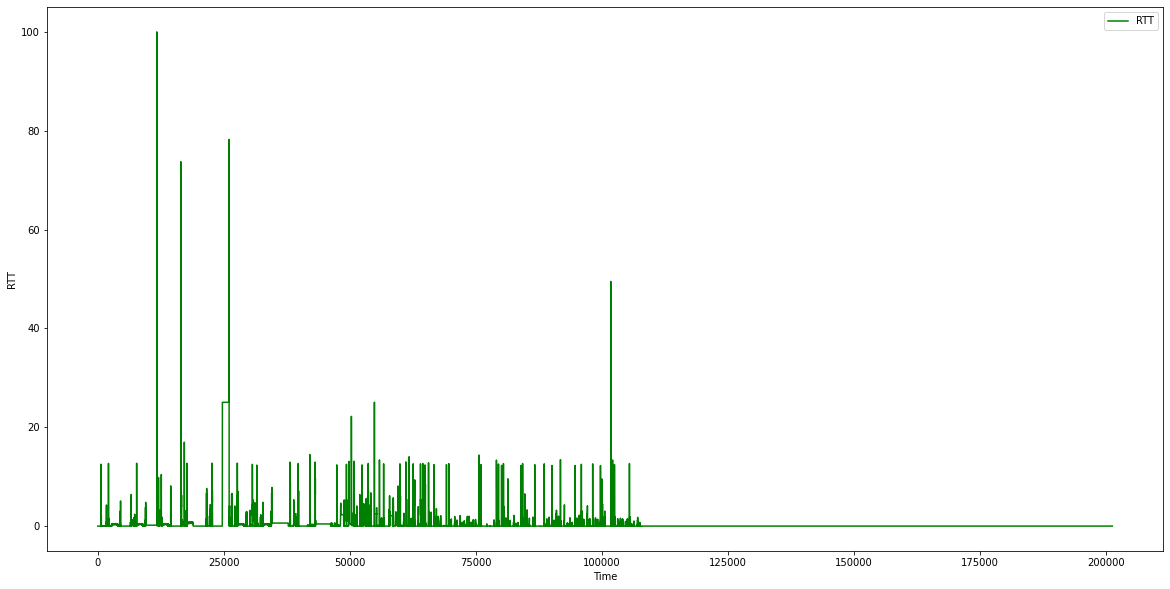

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(Y_test[50:,3], color = 'green', label = 'RTT')
# plt.plot(predicted[50:,0], color = 'red', label = 'Predicted Transfer')
plt.xlabel('Time')
plt.ylabel('RTT')
plt.legend()
plt.show()

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/unshuffled_norm_combined_data_train3.csv')
data2 = pd.DataFrame(columns = [ 'Transfer', 'Bandwidth', 'CongestionWindow','RTT', 'NetPower'])

data2['Transfer'] = df['Transfer']
data2['Bandwidth'] = df['Bandwidth']
data2['CongestionWindow'] = df['CongestionWindow']
data2['RTT'] = df['RTT'] * 100
data2['NetPower'] = df['NetPower']
train_set = data2.iloc[:,:].values

In [ ]:
train_X=[]
train_Y=[]
for i in range(100, len(train_set)):

        train_X.append(train_set[i-100:i,:])
        train_Y.append(train_set[i-1:i,:])

In [ ]:
X_train = np.array(train_X)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 5))

In [ ]:
regressor = load_model("/content/drive/MyDrive/RTT-seq2seq_data2.h5")
encoder_input_data=X_train
print(X_train.shape)
decoder_target_data=np.array(train_Y).astype(np.float32)
print(decoder_target_data.shape)
decoder_input_data = np.zeros(decoder_target_data.shape)
print(decoder_input_data.shape)
regressor.fit([encoder_input_data, decoder_input_data], decoder_target_data, epochs=1, batch_size=256)
regressor.save("/content/drive/MyDrive/RTT-seq2seq_data3.h5")


(201212, 100, 5)
(201212, 1, 5)
(201212, 1, 5)
Epoch 1/1
201212/201212 [==============================] - 232s 1ms/step - loss: 0.0034


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_1_4/concat:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'concatenate_2_4/concat:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [ ]:
regressor = load_model("/content/drive/MyDrive/RTT-seq2seq_data3.h5")
testdataframe = pd.read_csv("/content/drive/MyDrive/unshuffled_norm_combined_data_train3.csv")

testdata = pd.DataFrame(columns = [ 'Transfer', 'Bandwidth', 'CongestionWindow','RTT', 'NetPower'])

testdata['Transfer'] = testdataframe['Transfer']
testdata['Bandwidth'] = testdataframe['Bandwidth']
testdata['CongestionWindow'] = testdataframe['CongestionWindow']
testdata['RTT'] = testdataframe['RTT'] * 100
testdata['NetPower'] = testdataframe['NetPower']

dataset_total = pd.concat((data2,testdata),axis=0)

In [ ]:
inputs = dataset_total[len(dataset_total) - len(testdata) - 100:].values
print(inputs)
print(inputs.shape)

[[0.02822266 0.00121121 0.12753036 0.00124    0.00054222]
 [0.03496094 0.0015015  0.12753036 0.00151    0.0005527 ]
 [0.03408203 0.00146146 0.12753036 0.000918   0.00088773]
 ...
 [0.02490234 0.00107107 0.12753036 0.00155    0.00038525]
 [0.02832031 0.00122122 0.12753036 0.00111    0.00061206]
 [0.02695313 0.00116116 0.12753036 0.00225    0.00028696]]
(201412, 5)


In [ ]:
test_X=[]
test_Y=[]
for i in range(100, len(inputs)):

        test_X.append(inputs[i-100:i,:])
        test_Y.append(inputs[i-1:i,:])

X_test = np.array(test_X)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))

Y_test = np.array(test_Y).astype(np.float32)
decoder_output_target = Y_test
decoder_output_data = np.zeros(decoder_output_target.shape)

(201312, 100, 5)


In [ ]:
predicted = regressor.predict([X_test,decoder_output_data])
print(predicted.shape)

(201312, 1, 5)


In [ ]:
predicted = predicted.reshape(predicted.shape[0],5)
Y_test = Y_test.reshape(Y_test.shape[0],5)

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
rmse1=np.sqrt(np.mean(((predicted[50:,0]- Y_test[50:,0])**2)))
rmse2=np.sqrt(np.mean(((predicted[50:,1]- Y_test[50:,1])**2)))
rmse3=np.sqrt(np.mean(((predicted[50:,2]- Y_test[50:,2])**2)))
rmse4=np.sqrt(np.mean(((predicted[50:,3]- Y_test[50:,3])**2)))
rmse5=np.sqrt(np.mean(((predicted[50:,4]- Y_test[50:,4])**2)))
print(mean_squared_error(predicted[50:,0],Y_test[50:,0]))
print(mean_squared_error(predicted[50:,1],Y_test[50:,1]))
print(mean_squared_error(predicted[50:,2],Y_test[50:,2]))
print(mean_squared_error(predicted[50:,3], Y_test[50:,3]))
print(mean_squared_error(predicted[50:,4], Y_test[50:,4]))
print("****")
print(rmse1)
print(rmse2)
print(rmse3)
print(rmse4)
print(rmse5)


5.0152037e-05
5.6280787e-05
3.8595467e-06
4.5547727e-05
1.7895542e-06
****
0.0070818104
0.007502052
0.0019645728
0.006748906
0.0013377422


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/unshuffled_norm_combined_data_train4.csv')
data2 = pd.DataFrame(columns = [ 'Transfer', 'Bandwidth', 'CongestionWindow','RTT', 'NetPower'])

data2['Transfer'] = df['Transfer']
data2['Bandwidth'] = df['Bandwidth']
data2['CongestionWindow'] = df['CongestionWindow']
data2['RTT'] = df['RTT'] * 100
data2['NetPower'] = df['NetPower']
train_set = data2.iloc[:,:].values

In [ ]:
train_X=[]
train_Y=[]
for i in range(100, len(train_set)):

        train_X.append(train_set[i-100:i,:])
        train_Y.append(train_set[i-1:i,:])

In [ ]:
X_train = np.array(train_X)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 5))

In [ ]:
regressor = load_model("/content/drive/MyDrive/RTT-seq2seq_data3.h5")
encoder_input_data=X_train
print(X_train.shape)
decoder_target_data=np.array(train_Y).astype(np.float32)
print(decoder_target_data.shape)
decoder_input_data = np.zeros(decoder_target_data.shape)
print(decoder_input_data.shape)
regressor.fit([encoder_input_data, decoder_input_data], decoder_target_data, epochs=1, batch_size=256)
regressor.save("/content/drive/MyDrive/RTT-seq2seq_data4.h5")


(201212, 100, 5)
(201212, 1, 5)
(201212, 1, 5)
Epoch 1/1
201212/201212 [==============================] - 233s 1ms/step - loss: 0.0045


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_1_6/concat:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'concatenate_2_6/concat:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [ ]:
regressor = load_model("/content/drive/MyDrive/RTT-seq2seq_data4.h5")
testdataframe = pd.read_csv("/content/drive/MyDrive/unshuffled_norm_combined_data_train4.csv")

testdata = pd.DataFrame(columns = [ 'Transfer', 'Bandwidth', 'CongestionWindow','RTT', 'NetPower'])

testdata['Transfer'] = testdataframe['Transfer']
testdata['Bandwidth'] = testdataframe['Bandwidth']
testdata['CongestionWindow'] = testdataframe['CongestionWindow']
testdata['RTT'] = testdataframe['RTT'] * 100
testdata['NetPower'] = testdataframe['NetPower']

dataset_total = pd.concat((data2,testdata),axis=0)

In [ ]:
inputs = dataset_total[len(dataset_total) - len(testdata) - 100:].values
print(inputs)
print(inputs.shape)

[[4.23828130e-02 1.82182200e-03 7.17177560e-02 5.10000000e-04
  1.98737600e-03]
 [4.12109380e-02 1.77177200e-03 7.33082710e-02 1.35000000e-03
  7.30251000e-04]
 [3.99414060e-02 1.71171200e-03 7.53325620e-02 6.84000000e-04
  1.39574000e-03]
 ...
 [2.38281250e-02 1.02102100e-03 8.47310580e-02 1.50000000e-03
  3.81051000e-04]
 [1.50390630e-02 6.45645646e-01 8.47310580e-02 1.58000000e-03
  2.27112000e-04]
 [2.09960940e-02 9.02902903e-01 8.47310580e-02 5.18000000e-03
  9.70000000e-05]]
(201412, 5)


In [ ]:
test_X=[]
test_Y=[]
for i in range(100, len(inputs)):

        test_X.append(inputs[i-100:i,:])
        test_Y.append(inputs[i-1:i,:])

X_test = np.array(test_X)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))

Y_test = np.array(test_Y).astype(np.float32)
decoder_output_target = Y_test
decoder_output_data = np.zeros(decoder_output_target.shape)

(201312, 100, 5)


In [ ]:
predicted = regressor.predict([X_test,decoder_output_data])
print(predicted.shape)

(201312, 1, 5)


In [ ]:
predicted = predicted.reshape(predicted.shape[0],5)
Y_test = Y_test.reshape(Y_test.shape[0],5)

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
rmse1=np.sqrt(np.mean(((predicted[50:,0]- Y_test[50:,0])**2)))
rmse2=np.sqrt(np.mean(((predicted[50:,1]- Y_test[50:,1])**2)))
rmse3=np.sqrt(np.mean(((predicted[50:,2]- Y_test[50:,2])**2)))
rmse4=np.sqrt(np.mean(((predicted[50:,3]- Y_test[50:,3])**2)))
rmse5=np.sqrt(np.mean(((predicted[50:,4]- Y_test[50:,4])**2)))
print(mean_squared_error(predicted[50:,0],Y_test[50:,0]))
print(mean_squared_error(predicted[50:,1],Y_test[50:,1]))
print(mean_squared_error(predicted[50:,2],Y_test[50:,2]))
print(mean_squared_error(predicted[50:,3], Y_test[50:,3]))
print(mean_squared_error(predicted[50:,4], Y_test[50:,4]))
print("****")
print(rmse1)
print(rmse2)
print(rmse3)
print(rmse4)
print(rmse5)


0.00014775342
2.4106293e-05
4.3903758e-05
3.8608946e-06
5.030335e-07
****
0.012155387
0.004909816
0.006625991
0.001964916
0.00070924853


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/unshuffled_norm_combined_data_train5.csv')
data2 = pd.DataFrame(columns = [ 'Transfer', 'Bandwidth', 'CongestionWindow','RTT', 'NetPower'])

data2['Transfer'] = df['Transfer']
data2['Bandwidth'] = df['Bandwidth']
data2['CongestionWindow'] = df['CongestionWindow']
data2['RTT'] = df['RTT'] * 100
data2['NetPower'] = df['NetPower']
train_set = data2.iloc[:,:].values

In [ ]:
train_X=[]
train_Y=[]
for i in range(100, len(train_set)):

        train_X.append(train_set[i-100:i,:])
        train_Y.append(train_set[i-1:i,:])

In [ ]:
X_train = np.array(train_X)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 5))

In [ ]:
regressor = load_model("/content/drive/MyDrive/RTT-seq2seq_data4.h5")
encoder_input_data=X_train
print(X_train.shape)
decoder_target_data=np.array(train_Y).astype(np.float32)
print(decoder_target_data.shape)
decoder_input_data = np.zeros(decoder_target_data.shape)
print(decoder_input_data.shape)
regressor.fit([encoder_input_data, decoder_input_data], decoder_target_data, epochs=1, batch_size=256)
regressor.save("/content/drive/MyDrive/RTT-seq2seq_data5.h5")


(201212, 100, 5)
(201212, 1, 5)
(201212, 1, 5)
Epoch 1/1
201212/201212 [==============================] - 235s 1ms/step - loss: 0.0045


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_1_8/concat:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'concatenate_2_8/concat:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [ ]:
regressor = load_model("/content/drive/MyDrive/RTT-seq2seq_data5.h5")
testdataframe = pd.read_csv("/content/drive/MyDrive/unshuffled_norm_combined_data_train5.csv")

testdata = pd.DataFrame(columns = [ 'Transfer', 'Bandwidth', 'CongestionWindow','RTT', 'NetPower'])

testdata['Transfer'] = testdataframe['Transfer']
testdata['Bandwidth'] = testdataframe['Bandwidth']
testdata['CongestionWindow'] = testdataframe['CongestionWindow']
testdata['RTT'] = testdataframe['RTT'] * 100
testdata['NetPower'] = testdataframe['NetPower']

dataset_total = pd.concat((data2,testdata),axis=0)

In [ ]:
inputs = dataset_total[len(dataset_total) - len(testdata) - 100:].values
print(inputs)
print(inputs.shape)

[[2.75390625e-01 1.18118120e-02 1.46038170e-02 7.79000000e-05
  8.46380290e-02]
 [2.91015625e-01 1.25125130e-02 1.46038170e-02 4.45000000e-05
  1.56647854e-01]
 [2.57812500e-01 1.11111110e-02 1.70618850e-02 8.90000000e-05
  6.92676200e-02]
 ...
 [3.13476563e-01 1.35135140e-02 1.70618850e-02 4.27000000e-05
  1.75853273e-01]
 [3.13476563e-01 1.35135140e-02 1.70618850e-02 4.45000000e-05
  1.68657304e-01]
 [2.89062500e-01 1.24124120e-02 1.70618850e-02 7.98000000e-04
  8.66988000e-03]]
(201412, 5)


In [ ]:
test_X=[]
test_Y=[]
for i in range(100, len(inputs)):

        test_X.append(inputs[i-100:i,:])
        test_Y.append(inputs[i-1:i,:])

X_test = np.array(test_X)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))

Y_test = np.array(test_Y).astype(np.float32)
decoder_output_target = Y_test
decoder_output_data = np.zeros(decoder_output_target.shape)

(201312, 100, 5)


In [ ]:
predicted = regressor.predict([X_test,decoder_output_data])
print(predicted.shape)

(201312, 1, 5)


In [ ]:
predicted = predicted.reshape(predicted.shape[0],5)
Y_test = Y_test.reshape(Y_test.shape[0],5)

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
rmse1=np.sqrt(np.mean(((predicted[50:,0]- Y_test[50:,0])**2)))
rmse2=np.sqrt(np.mean(((predicted[50:,1]- Y_test[50:,1])**2)))
rmse3=np.sqrt(np.mean(((predicted[50:,2]- Y_test[50:,2])**2)))
rmse4=np.sqrt(np.mean(((predicted[50:,3]- Y_test[50:,3])**2)))
rmse5=np.sqrt(np.mean(((predicted[50:,4]- Y_test[50:,4])**2)))
print(mean_squared_error(predicted[50:,0],Y_test[50:,0]))
print(mean_squared_error(predicted[50:,1],Y_test[50:,1]))
print(mean_squared_error(predicted[50:,2],Y_test[50:,2]))
print(mean_squared_error(predicted[50:,3], Y_test[50:,3]))
print(mean_squared_error(predicted[50:,4], Y_test[50:,4]))
print("****")
print(rmse1)
print(rmse2)
print(rmse3)
print(rmse4)
print(rmse5)


0.00016794063
3.929692e-05
0.000151937
0.0005571381
1.8537554e-05
****
0.012959191
0.0062687257
0.012326273
0.023603773
0.004305526


In [ ]:
regressor = load_model("/content/drive/MyDrive/RTT-seq2seq_data5.h5")
testdataframe = pd.read_csv("/content/drive/MyDrive/unshuffled_norm_combined_data_test.csv")

testdata = pd.DataFrame(columns = [ 'Transfer', 'Bandwidth', 'CongestionWindow','RTT', 'NetPower'])

testdata['Transfer'] = testdataframe['Transfer']
testdata['Bandwidth'] = testdataframe['Bandwidth']
testdata['CongestionWindow'] = testdataframe['CongestionWindow']
testdata['RTT'] = testdataframe['RTT'] * 100
testdata['NetPower'] = testdataframe['NetPower']


In [ ]:
inputs = testdata.values
test_X=[]
test_Y=[]
for i in range(100, len(testdata)):

        test_X.append(inputs[i-100:i,:])
        test_Y.append(inputs[i-1:i,:])

X_test = np.array(test_X)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))

Y_test = np.array(test_Y).astype(np.float32)
decoder_output_target = Y_test
decoder_output_data = np.zeros(decoder_output_target.shape)

(41915, 100, 5)


In [ ]:
predicted = regressor.predict([X_test,decoder_output_data])
print(predicted.shape)

(41915, 1, 5)


In [ ]:
predicted = predicted.reshape(predicted.shape[0],5)
Y_test = Y_test.reshape(Y_test.shape[0],5)

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
rmse1=np.sqrt(np.mean(((predicted[50:,0]- Y_test[50:,0])**2)))
rmse2=np.sqrt(np.mean(((predicted[50:,1]- Y_test[50:,1])**2)))
rmse3=np.sqrt(np.mean(((predicted[50:,2]- Y_test[50:,2])**2)))
rmse4=np.sqrt(np.mean(((predicted[50:,3]- Y_test[50:,3])**2)))
rmse5=np.sqrt(np.mean(((predicted[50:,4]- Y_test[50:,4])**2)))
print(mean_squared_error(predicted[50:,0],Y_test[50:,0]))
print(mean_squared_error(predicted[50:,1],Y_test[50:,1]))
print(mean_squared_error(predicted[50:,2],Y_test[50:,2]))
print(mean_squared_error(predicted[50:,3], Y_test[50:,3]))
print(mean_squared_error(predicted[50:,4], Y_test[50:,4]))
print("****")
print(rmse1)
print(rmse2)
print(rmse3)
print(rmse4)
print(rmse5)


9.353039e-05
2.1558992e-05
2.2974855e-05
0.00014742282
1.0665755e-05
****
0.009671112
0.004643166
0.004793209
0.01214178
0.0032658468


In [ ]:
print(Y_test[:,3])
print(predicted[:,3])

[2.86025e-02 2.86025e-02 2.86025e-02 ... 4.66000e-04 4.45000e-05
 4.27000e-05]
[0.03274801 0.03274801 0.03274801 ... 0.         0.         0.        ]


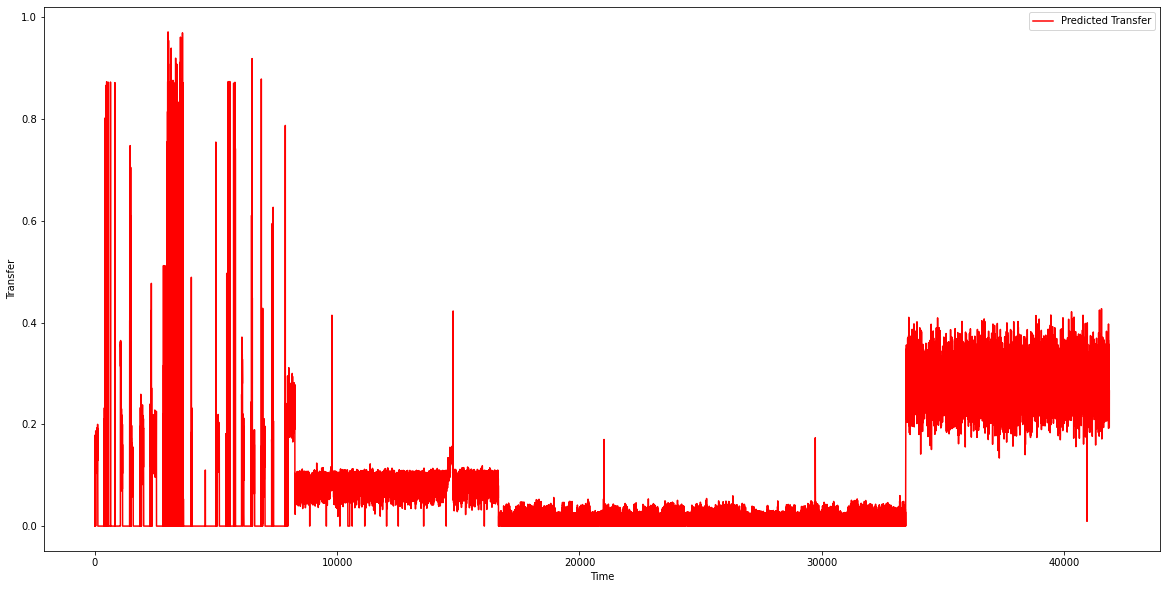

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(predicted[50:,0], color = 'red', label = 'Predicted Transfer')
plt.xlabel('Time')
plt.ylabel('Transfer')
plt.legend()
plt.show()

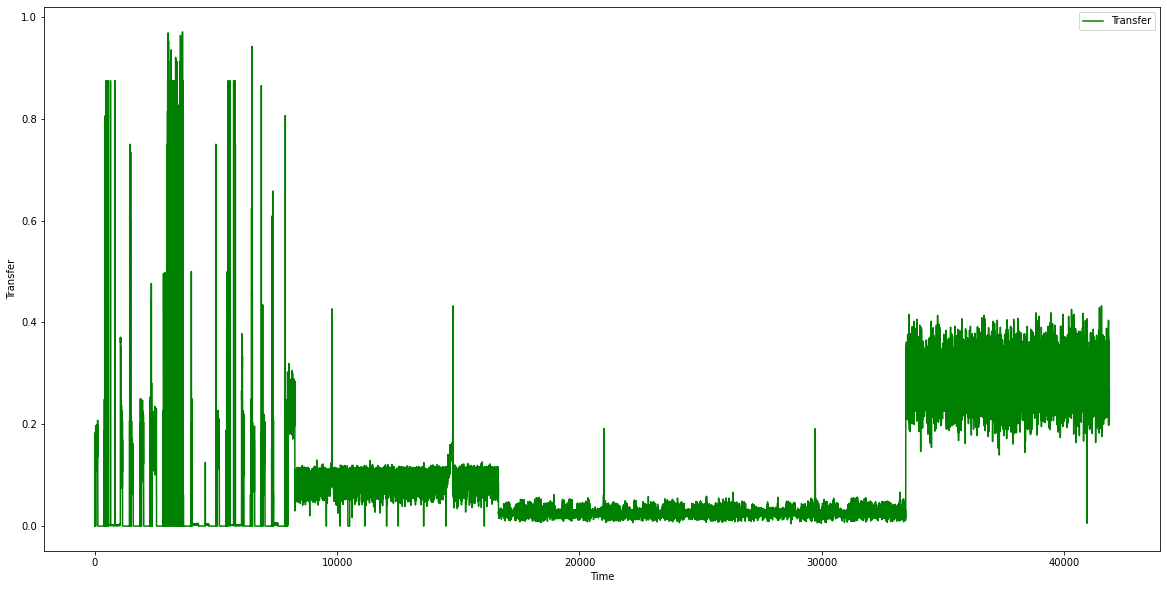

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(Y_test[50:,0], color = 'green', label = 'Transfer')
# plt.plot(predicted[50:,0], color = 'red', label = 'Predicted Transfer')
plt.xlabel('Time')
plt.ylabel('Transfer')
plt.legend()
plt.show()

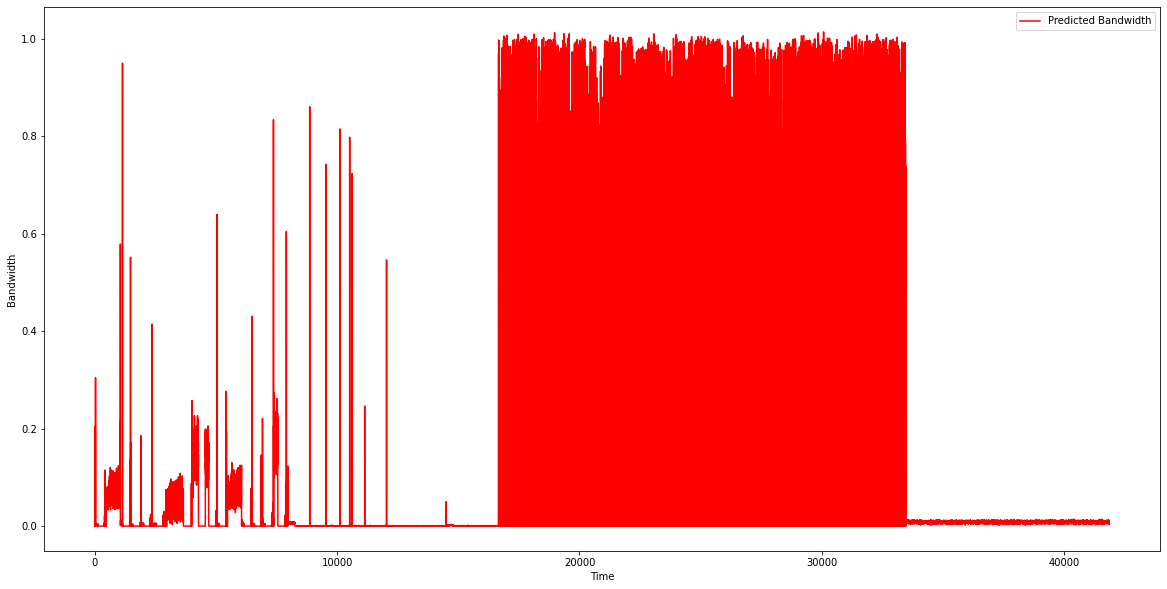

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(predicted[50:,1], color = 'red', label = 'Predicted Bandwidth')
plt.xlabel('Time')
plt.ylabel('Bandwidth')
plt.legend()
plt.show()

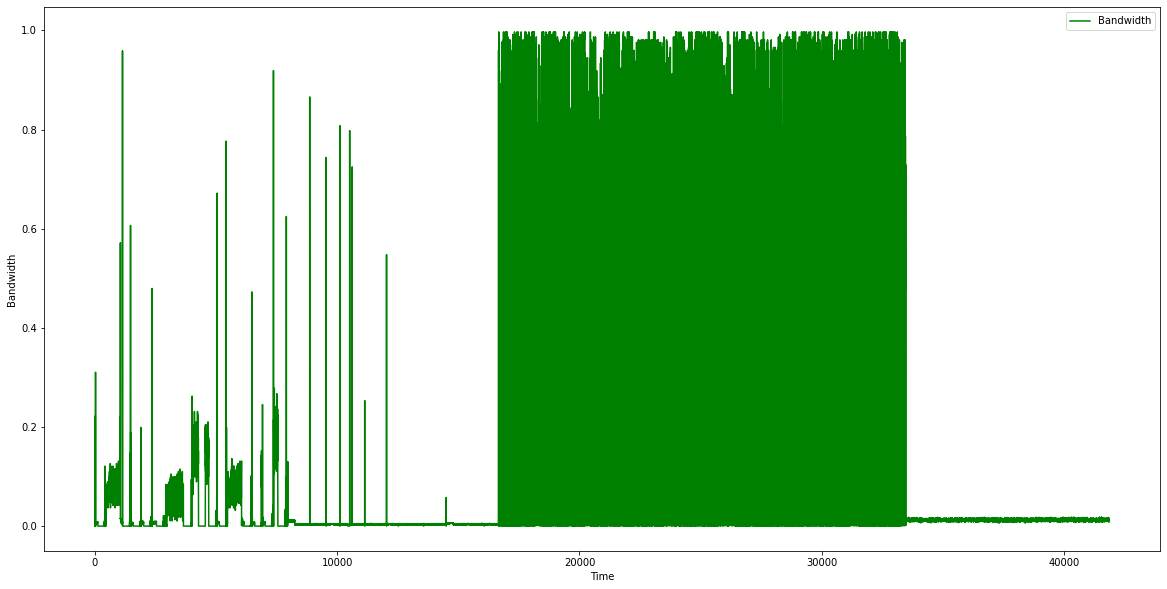

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(Y_test[50:,1], color = 'green', label = 'Bandwidth')
plt.xlabel('Time')
plt.ylabel('Bandwidth')
plt.legend()
plt.show()

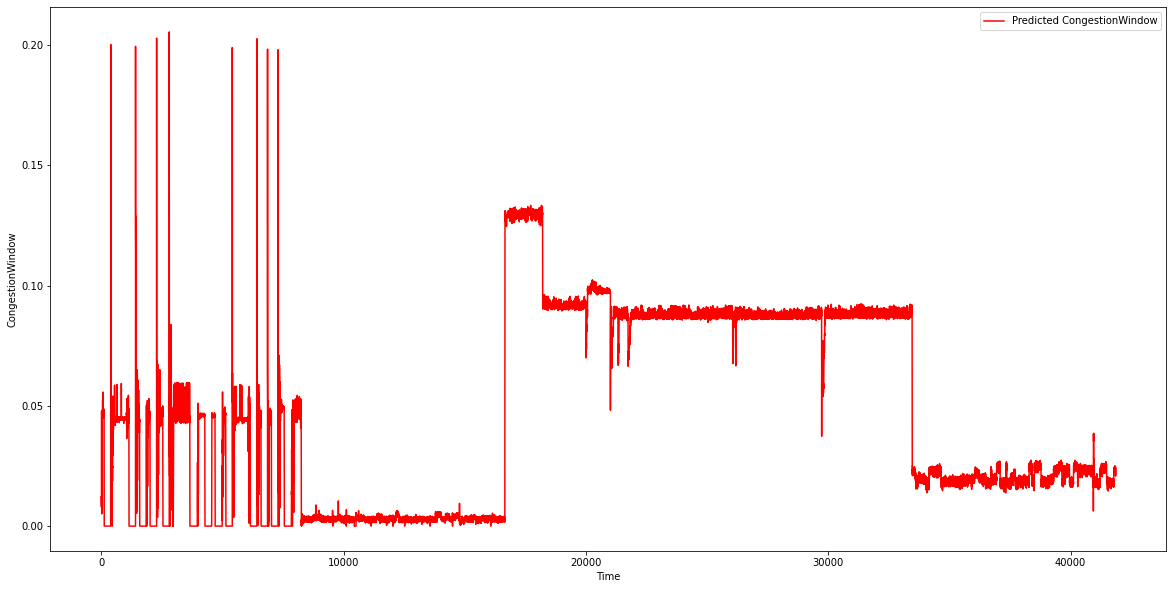

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(predicted[50:,2], color = 'red', label = 'Predicted CongestionWindow')
plt.xlabel('Time')
plt.ylabel('CongestionWindow')
plt.legend()
plt.show()

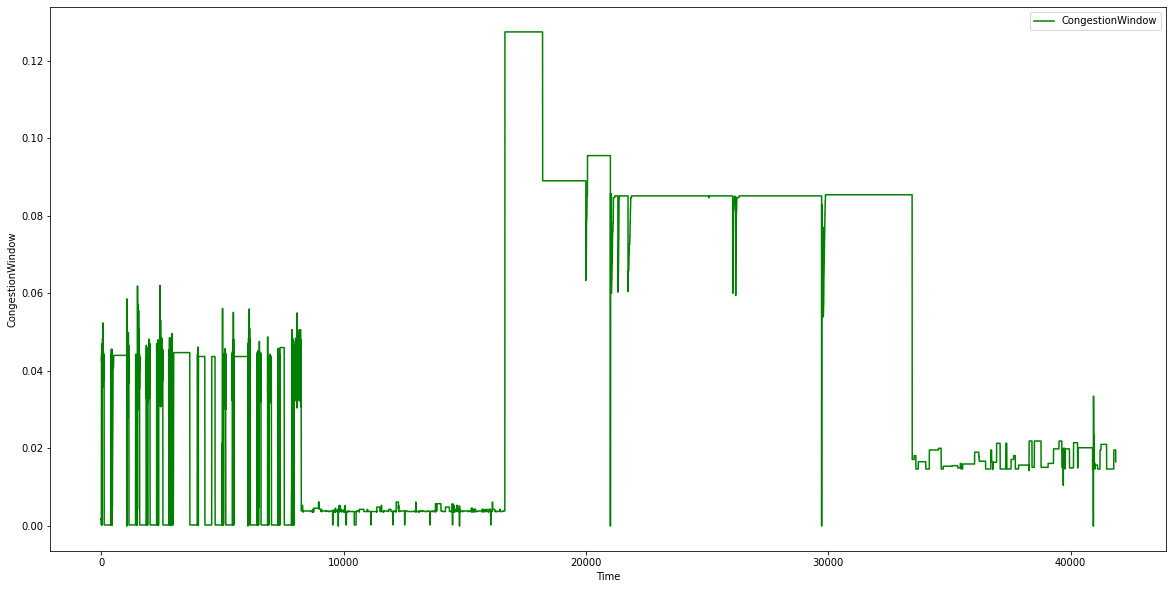

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(Y_test[50:,2], color = 'green', label = 'CongestionWindow')
plt.xlabel('Time')
plt.ylabel('CongestionWindow')
plt.legend()
plt.show()

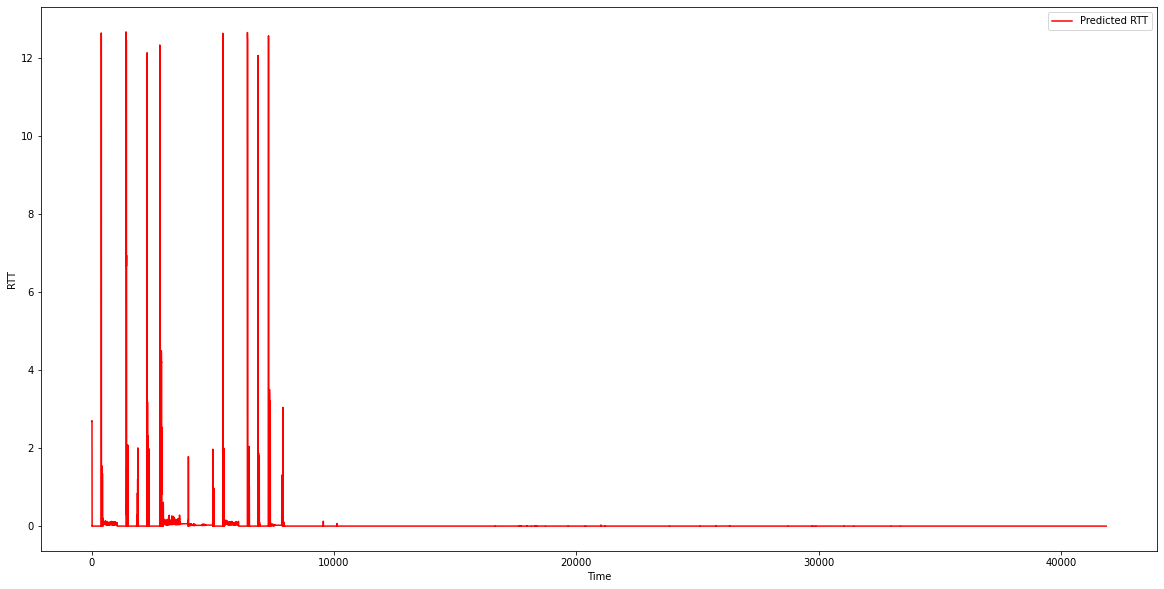

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(predicted[50:,3], color = 'red', label = 'Predicted RTT')
plt.xlabel('Time')
plt.ylabel('RTT')
plt.legend()
plt.show()

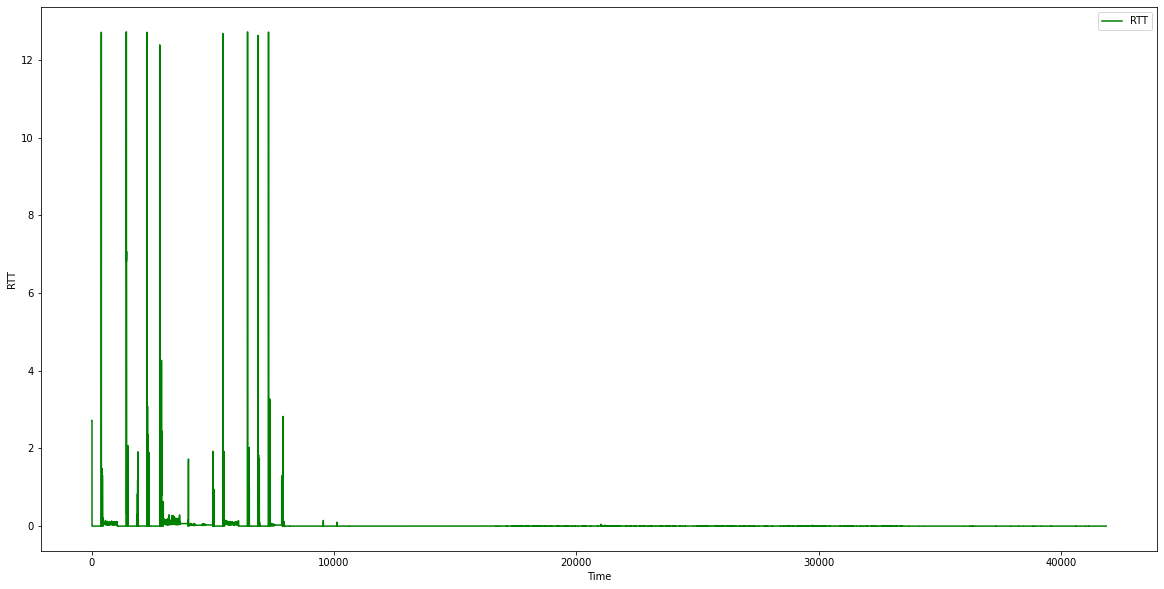

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(Y_test[50:,3], color = 'green', label = 'RTT')
plt.xlabel('Time')
plt.ylabel('RTT')
plt.legend()
plt.show()

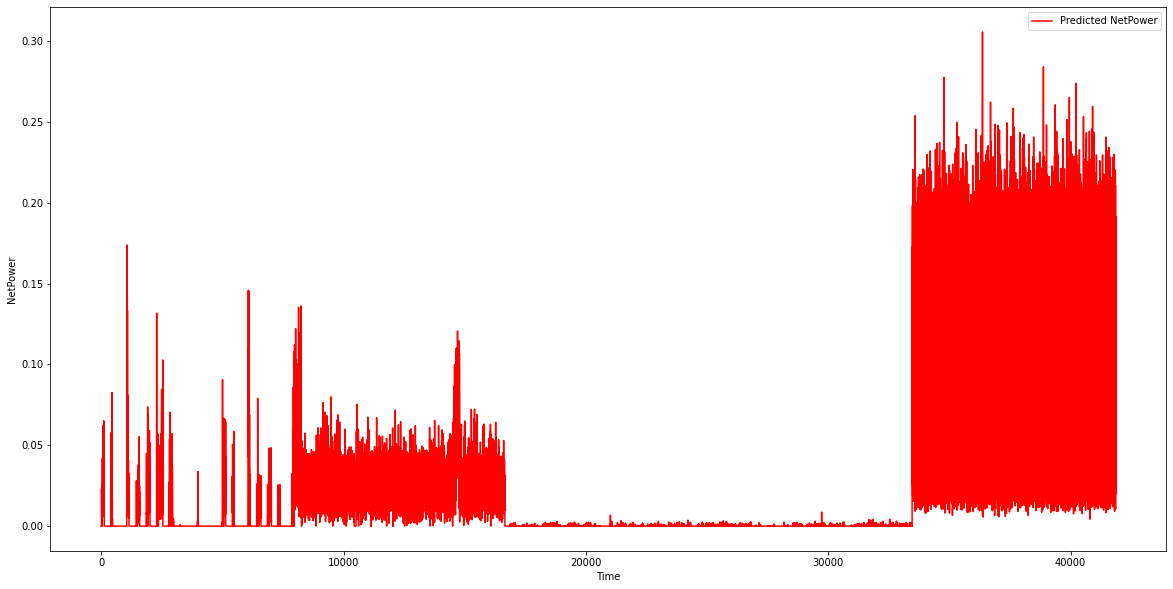

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(predicted[50:,4], color = 'red', label = 'Predicted NetPower')
plt.xlabel('Time')
plt.ylabel('NetPower')
plt.legend()
plt.show()

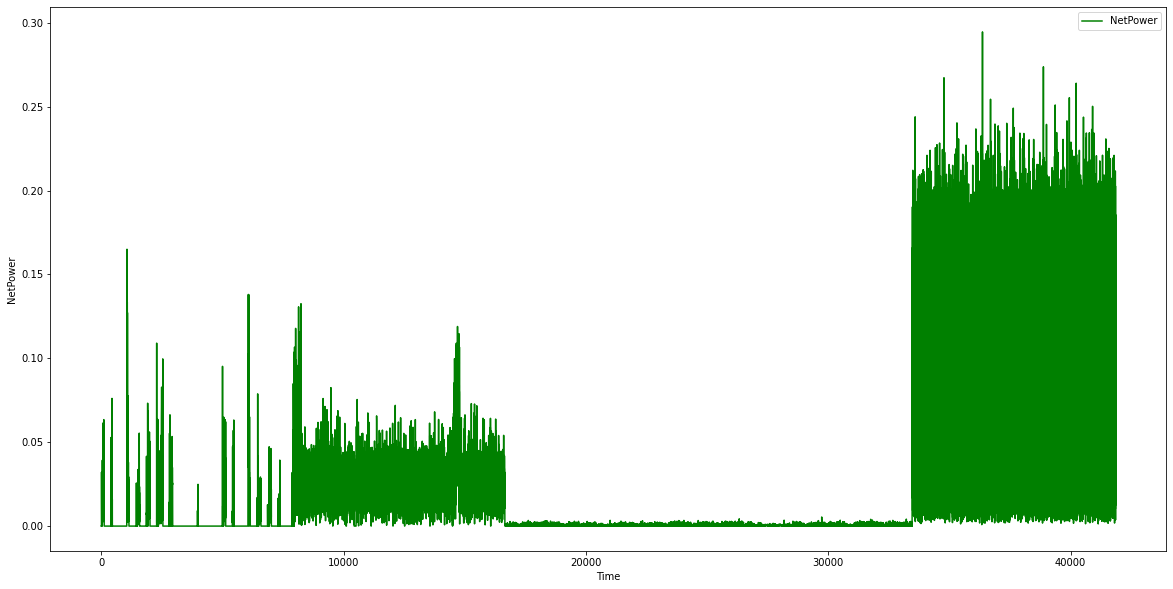

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(Y_test[50:,4], color = 'green', label = 'NetPower')
plt.xlabel('Time')
plt.ylabel('NetPower')
plt.legend()
plt.show()

In [ ]:
# test
import csv
import numpy as np
from keras.models import load_model
test = []
with open("/content/drive/MyDrive/unshuffled_norm_combined_data_test.csv", 'r') as r:
    c = 0
    reader = csv.reader(r)
    for row in reader:
        if c==0:
            c+=1
            continue
        r1 = []
        for j in range(2,len(row)):
          if j in [3,4,8,9,10]:
            if j ==9:
              row[j]= float(row[j])*100
            r1.append(float(row[j]))
        
        test.append(np.array(r1[:]))
            
        c+=1
print(np.array(test).shape)
regressor = load_model("/content/drive/MyDrive/RTT-seq2seq_data5.h5")

test_X = []
test_Y = []

for i in range(100, len(test)):
        test_X.append(test[i-100:i])
        test_Y.append(test[i-1:i])


X_test = np.array(test_X)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))

Y_test = np.array(test_Y).astype(np.float32)
decoder_output_target = Y_test
decoder_output_data = np.zeros(decoder_output_target.shape)


(42015, 5)
(41915, 100, 5)


In [ ]:
predicted = regressor.predict([X_test,decoder_output_data])
print(predicted.shape)

(41915, 1, 5)


In [ ]:
Y_test = Y_test.reshape(Y_test.shape[0],1,5)
print(Y_test.shape)

(41915, 1, 5)


In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
rmse1=np.sqrt(np.mean(((predicted[:,:,0]- Y_test[:,:,0])**2)))
rmse2=np.sqrt(np.mean(((predicted[:,:,1]- Y_test[:,:,1])**2)))
rmse3=np.sqrt(np.mean(((predicted[:,:,2]- Y_test[:,:,2])**2)))
rmse4=np.sqrt(np.mean(((predicted[:,:,3]- Y_test[:,:,3])**2)))
rmse5=np.sqrt(np.mean(((predicted[:,:,4]- Y_test[:,:,4])**2)))
print(mean_squared_error(predicted[:,:,0],Y_test[:,:,0]))
print(mean_squared_error(predicted[:,:,1],Y_test[:,:,1]))
print(mean_squared_error(predicted[:,:,2],Y_test[:,:,2]))
print(mean_squared_error(predicted[:,:,3], Y_test[:,:,3]))
print(mean_squared_error(predicted[:,:,4], Y_test[:,:,4]))
print("****")
print(rmse1)
print(rmse2)
print(rmse3)
print(rmse4)
print(rmse5)

9.3649374e-05
2.1541771e-05
2.3106697e-05
0.00014813986
1.0653032e-05
****
0.009677261
0.0046413112
0.004806943
0.012171272
0.0032638984


In [ ]:
print(Y_test[0,:,:])

[[0.         0.         0.00014459 0.0286025  0.        ]]


In [ ]:
train = []
Y = []
X = []
Xt = []
Yt = []
Yd = []
with open("/content/drive/MyDrive/unshuffled_norm_combined_data_test.csv", 'r') as r:
    c = 0
    reader = csv.reader(r)
    for row in reader:
      
      if c<100:

        c+=1
        continue;
      
      r1 = []
      for j in range(2,len(row)):
        
        if j in [3,4,8,9,10]:
          if j ==3:
            row[j] = Y_test[c-101,:,0]
          elif j == 4:
            row[j] = Y_test[c-101,:,1]
          elif j==8:
            row[j] = Y_test[c-101,:,2]
          elif j==9:
            row[j] = Y_test[c-101,:,3]/100
          elif j==10:
            row[j] = Y_test[c-101,:,4]
      
        r1.append(float(row[j]))
      if r1[len(r1)-8]==1 or r1[len(r1)-9]==1 or r1[len(r1)-10]==1:
        X.append(np.array(r1[:len(r1)-7]))
        
              #Y.append(numpy.array(i[len(i)-7:]))
        Yd.append(r1[len(r1)-7:])
              #train.append(r1)
              #print(r1)
      c+=1
     

In [ ]:
print(np.array(X).shape)

(41916, 23)


In [ ]:
import numpy
Y1=[]
Y2=[]
Y3=[]
Y4=[]
Y5=[]
Y6=[]
Y7=[]
print(len(Yd))
print(len(Y_test))
for i in range(0,len(Yd)):
    Y1.append(Yd[i][0])
    Y2.append(Yd[i][1])
    Y3.append(Yd[i][2])
    Y4.append(Yd[i][3])
    Y5.append(Yd[i][4])
    Y6.append(Yd[i][5])
    Y7.append(Yd[i][6])
Xout = numpy.array(X)
Y1 = numpy.array(Y1)
Y2 = numpy.array(Y2)
Y3 = numpy.array(Y3)
Y4 = numpy.array(Y4)
Y5 = numpy.array(Y5)
Y6 = numpy.array(Y6)
Y7 = numpy.array(Y7)
print(Xout.shape)

41916
41915
(41916, 23)


In [ ]:
import keras
loaded_model = keras.models.load_model('/content/drive/MyDrive/shuffled_model_d4.h5')
score = loaded_model.evaluate(Xout, y=[Y1,Y2,Y3,Y4,Y5,Y6,Y7], verbose=0)
for i in range(0,len(score)):
    print("%s: %.2f%%" % (loaded_model.metrics_names[i], score[i]*100))

predicted = loaded_model.predict(Xout)
p_classes = numpy.argmax(predicted,axis=1)

loss: 5.27%
dense_42_loss: 0.00%
dense_43_loss: 0.00%
dense_44_loss: 0.29%
dense_45_loss: 0.60%
dense_46_loss: 1.36%
dense_47_loss: 2.72%
dense_48_loss: 0.31%
dense_42_acc: 100.00%
dense_43_acc: 100.00%
dense_44_acc: 100.00%
dense_45_acc: 99.90%
dense_46_acc: 100.00%
dense_47_acc: 99.94%
dense_48_acc: 100.00%


In [ ]:
p = []

for x in numpy.nditer(predicted):
    xi = []
    for i in range(0,7):

        if x[i] < float(0.5):
            xi.append(0.0)
        else:
            xi.append(1.0)
    p.append(xi)

count = 0
for i in range(0,len(Yd)):
    v = 1
    for j in range(0,len(Yd[i])):
        if Yd[i][j]!=p[i][j]:
            v = 0
            break
    if v==1:
        count+=1

print(count)
print((count/len(Yd))*100)

#print(history.history.keys())


41868
99.88548525622673


In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


loss


Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
[[16707     0]
 [    0 25209]]
Predicted    0.0    1.0    All
Actual                        
0.0        16707      0  16707
1.0            0  25209  25209
All        16707  25209  41916







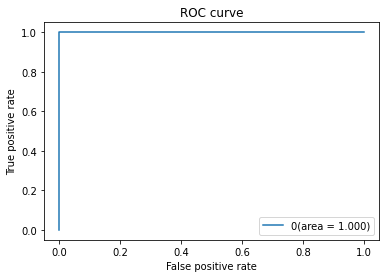

dense_42_loss


Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
[[16806     0]
 [    0 25110]]
Predicted    0.0    1.0    All
Actual                        
0.0        16806      0  16806
1.0            0  25110  25110
All        16806  25110  41916







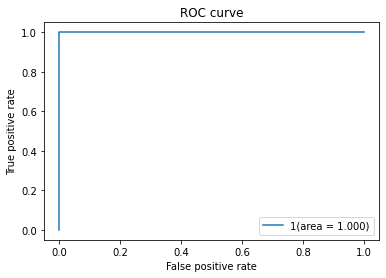

dense_43_loss


Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
[[30251     0]
 [    0 11665]]
Predicted    0.0    1.0    All
Actual                        
0.0        30251      0  30251
1.0            0  11665  11665
All        30251  11665  41916







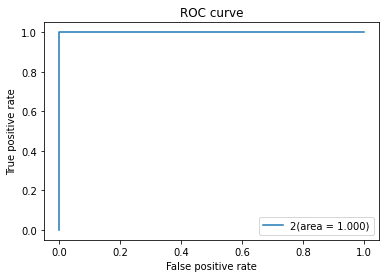

dense_44_loss


Accuracy: 0.998998
Precision: 0.998998
Recall: 0.998998
F1 score: 0.998998
Cohens kappa: 0.997993
[[20068     0]
 [   42 21806]]
Predicted    0.0    1.0    All
Actual                        
0.0        20068      0  20068
1.0           42  21806  21848
All        20110  21806  41916







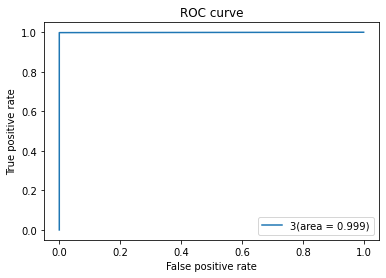

dense_45_loss


Accuracy: 0.999976
Precision: 0.999976
Recall: 0.999976
F1 score: 0.999976
Cohens kappa: 0.999840
[[38513     1]
 [    0  3402]]
Predicted    0.0   1.0    All
Actual                       
0.0        38513     1  38514
1.0            0  3402   3402
All        38513  3403  41916







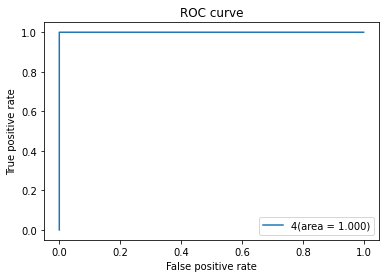

dense_46_loss


Accuracy: 0.999356
Precision: 0.999356
Recall: 0.999356
F1 score: 0.999356
Cohens kappa: 0.998710
[[20208     0]
 [   27 21681]]
Predicted    0.0    1.0    All
Actual                        
0.0        20208      0  20208
1.0           27  21681  21708
All        20235  21681  41916







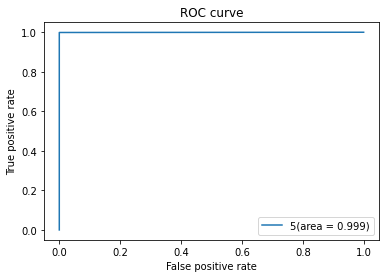

dense_47_loss


Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
[[25110     0]
 [    0 16806]]
Predicted    0.0    1.0    All
Actual                        
0.0        25110      0  25110
1.0            0  16806  16806
All        25110  16806  41916







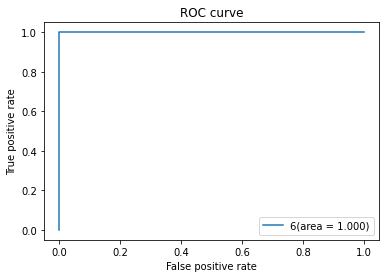

In [ ]:
%matplotlib inline

for j in range(0,7):
    Yt_1=[]
    p_1=[]    
    
    for i in range(0,len(Yd)):
        Yt_1.append(Yd[i][j])
        if(p[i][j]<0.5):
          p_1.append(0.0)
        else:
          p_1.append(1.0)
        # p_1.append(np.argmax(p[i][j],axis=1))

    
    # plt.scatter(Yt_1,p_1)
    # plt.xlabel("True")
    # plt.ylabel("Predict")
    # print(Yt_1)
    # print(p_1)
    print(loaded_model.metrics_names[j])
    print("\n")
    accuracy = accuracy_score(Yt_1, p_1)
    print('Accuracy: %f' % accuracy)

    # precision tp / (tp + fp)
    precision = precision_score(Yt_1, p_1, average='micro')
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(Yt_1, p_1, average='micro')
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(Yt_1, p_1, average='micro')
    print('F1 score: %f' % f1)

    # kappa
    kappa = cohen_kappa_score(Yt_1, p_1)
    print('Cohens kappa: %f' % kappa)

    # ROC AUC
    # auc = roc_auc_score(Yt_1, p_1)
    # print('ROC AUC: %f' % auc)
    
    fp, tp, thresholds_keras = roc_curve(Yt_1,p_1)
    
    auc_rf = auc(fp,tp)
    plt.plot(fp,tp,label=str(j)+"(area = {:.3f})".format(auc_rf))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')

    # confusion matrix
    matrix = confusion_matrix(Yt_1, p_1)
    print(matrix)

    exp_series = pd.Series(Yt_1)
    pred_series = pd.Series(p_1)
    print(pd.crosstab(exp_series, pred_series, rownames=['Actual'], colnames=['Predicted'], margins=True))
    print("\n\n\n\n")
    plt.savefig('/content/drive/MyDrive/ROC'+str(j)+'.png')
    plt.show()
    